In [1]:

# imports
import os
import sys
import types
import json

# figure size/format
fig_width = 7
fig_height = 5
fig_format = 'retina'
fig_dpi = 96

# matplotlib defaults / format
try:
  import matplotlib.pyplot as plt
  plt.rcParams['figure.figsize'] = (fig_width, fig_height)
  plt.rcParams['figure.dpi'] = fig_dpi
  plt.rcParams['savefig.dpi'] = fig_dpi
  from IPython.display import set_matplotlib_formats
  set_matplotlib_formats(fig_format)
except Exception:
  pass

# plotly use connected mode
try:
  import plotly.io as pio
  pio.renderers.default = "notebook_connected"
except Exception:
  pass

# enable pandas latex repr when targeting pdfs
try:
  import pandas as pd
  if fig_format == 'pdf':
    pd.set_option('display.latex.repr', True)
except Exception:
  pass



# output kernel dependencies
kernel_deps = dict()
for module in list(sys.modules.values()):
  # Some modules play games with sys.modules (e.g. email/__init__.py
  # in the standard library), and occasionally this can cause strange
  # failures in getattr.  Just ignore anything that's not an ordinary
  # module.
  if not isinstance(module, types.ModuleType):
    continue
  path = getattr(module, "__file__", None)
  if not path:
    continue
  if path.endswith(".pyc") or path.endswith(".pyo"):
    path = path[:-1]
  if not os.path.exists(path):
    continue
  kernel_deps[path] = os.stat(path).st_mtime
print(json.dumps(kernel_deps))

# set run_path if requested
if r'E:\OneDrive - Auburn University Montgomery\teaching\AUM\STAT 4160 Productivity Tools\lectureNotes\quarto-demo':
  os.chdir(r'E:\OneDrive - Auburn University Montgomery\teaching\AUM\STAT 4160 Productivity Tools\lectureNotes\quarto-demo')

# reset state
%reset

def ojs_define(**kwargs):
  import json
  try:
    # IPython 7.14 preferred import
    from IPython.display import display, HTML
  except:
    from IPython.core.display import display, HTML

  # do some minor magic for convenience when handling pandas
  # dataframes
  def convert(v):
    try:
      import pandas as pd
    except ModuleNotFoundError: # don't do the magic when pandas is not available
      return v
    if type(v) == pd.Series:
      v = pd.DataFrame(v)
    if type(v) == pd.DataFrame:
      j = json.loads(v.T.to_json(orient='split'))
      return dict((k,v) for (k,v) in zip(j["index"], j["data"]))
    else:
      return v
  
  v = dict(contents=list(dict(name=key, value=convert(value)) for (key, value) in kwargs.items()))
  display(HTML('<script type="ojs-define">' + json.dumps(v) + '</script>'), metadata=dict(ojs_define = True))
globals()["ojs_define"] = ojs_define


C:\Users\ywang2\AppData\Local\Temp\ipykernel_19416\2615516261.py:20: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats(fig_format)


{"C:\\Users\\ywang2\\.conda\\envs\\stat1010\\Lib\\importlib\\_bootstrap.py": 1692878958.0, "C:\\Users\\ywang2\\.conda\\envs\\stat1010\\Lib\\importlib\\_bootstrap_external.py": 1692878958.0, "C:\\Users\\ywang2\\.conda\\envs\\stat1010\\Lib\\zipimport.py": 1692878958.0, "C:\\Users\\ywang2\\.conda\\envs\\stat1010\\Lib\\codecs.py": 1692878958.0, "C:\\Users\\ywang2\\.conda\\envs\\stat1010\\Lib\\encodings\\aliases.py": 1692878958.0, "C:\\Users\\ywang2\\.conda\\envs\\stat1010\\Lib\\encodings\\__init__.py": 1692878958.0, "C:\\Users\\ywang2\\.conda\\envs\\stat1010\\Lib\\encodings\\utf_8.py": 1692878958.0, "C:\\Users\\ywang2\\.conda\\envs\\stat1010\\Lib\\abc.py": 1692878958.0, "C:\\Users\\ywang2\\.conda\\envs\\stat1010\\Lib\\io.py": 1692878958.0, "C:\\Users\\ywang2\\.conda\\envs\\stat1010\\Lib\\stat.py": 1692878958.0, "C:\\Users\\ywang2\\.conda\\envs\\stat1010\\Lib\\_collections_abc.py": 1692878958.0, "C:\\Users\\ywang2\\.conda\\envs\\stat1010\\Lib\\genericpath.py": 1692878958.0, "C:\\Users\\ywan

In [2]:
# Default values (overridden by -P at render time)
SYMBOL = "AAPL"
START  = "2018-01-01"
END    = ""
ROLL   =  20

In [3]:
#| echo: true
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from pathlib import Path

# SYMBOL = params.get("symbol", "AAPL")
# START  = params.get("start_date", "2018-01-01")
# END    = params.get("end_date", "")
# ROLL   = int(params.get("rolling", 20))
if not END:
  END = pd.Timestamp.today().strftime("%Y-%m-%d")

In [4]:
#| echo: true
try:
  data = yf.download(SYMBOL, start=START, end=END, auto_adjust=True, progress=False)
except Exception as e:
  # Synthetic fallback
  idx = pd.bdate_range(START, END)
  rng = np.random.default_rng(42)
  ret = rng.normal(0, 0.01, len(idx))
  price = 100 * np.exp(np.cumsum(ret))
  vol = rng.integers(1e5, 5e6, len(idx))
  data = pd.DataFrame({"Close": price, "Volume": vol}, index=idx)

df = (data.rename(columns=str.lower)[["close","volume"]]
        .dropna()
        .assign(log_return=lambda d: np.log(d["close"]).diff()))
df["roll_mean"] = df["log_return"].rolling(ROLL, min_periods=ROLL//2).mean()
df["roll_vol"]  = df["log_return"].rolling(ROLL, min_periods=ROLL//2).std()
df = df.dropna()

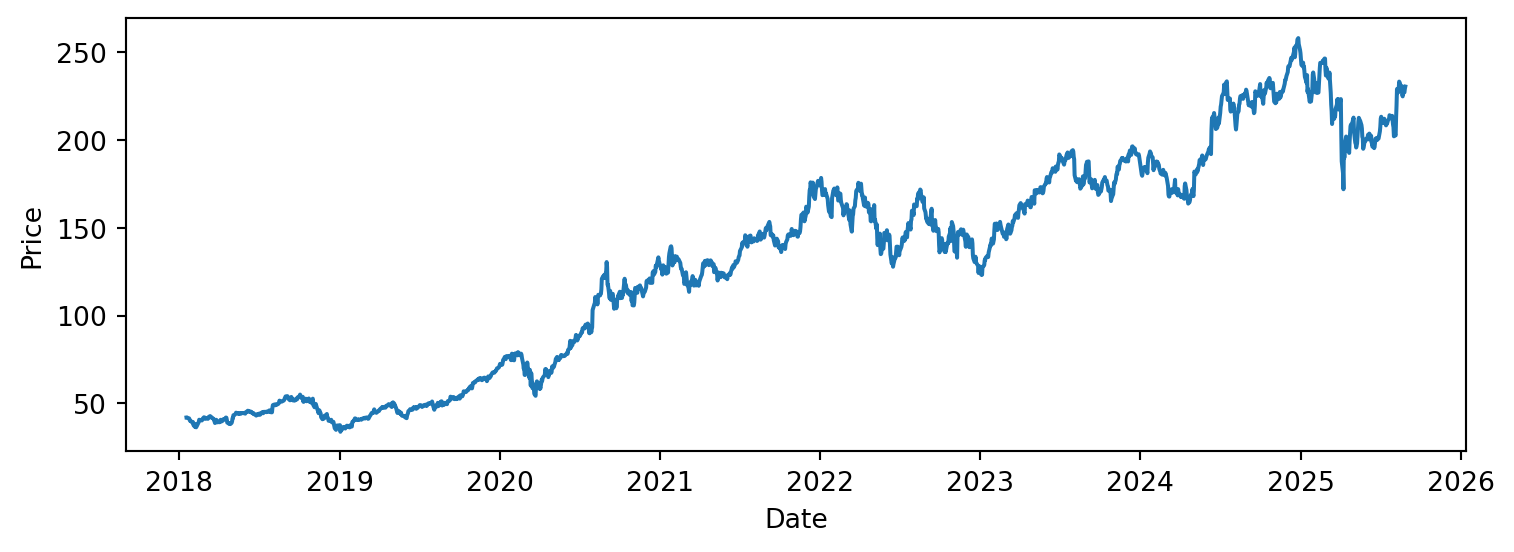

In [5]:
#| label: fig-price
#| fig-cap: '{SYMBOL} — Adjusted Close'
#| fig-alt: Line chart showing adjusted close price of the selected stock over time.
#| echo: false
fig, ax = plt.subplots(figsize=(8,3))
ax.plot(df.index, df["close"])
ax.set_xlabel("Date"); ax.set_ylabel("Price")
fig.tight_layout()

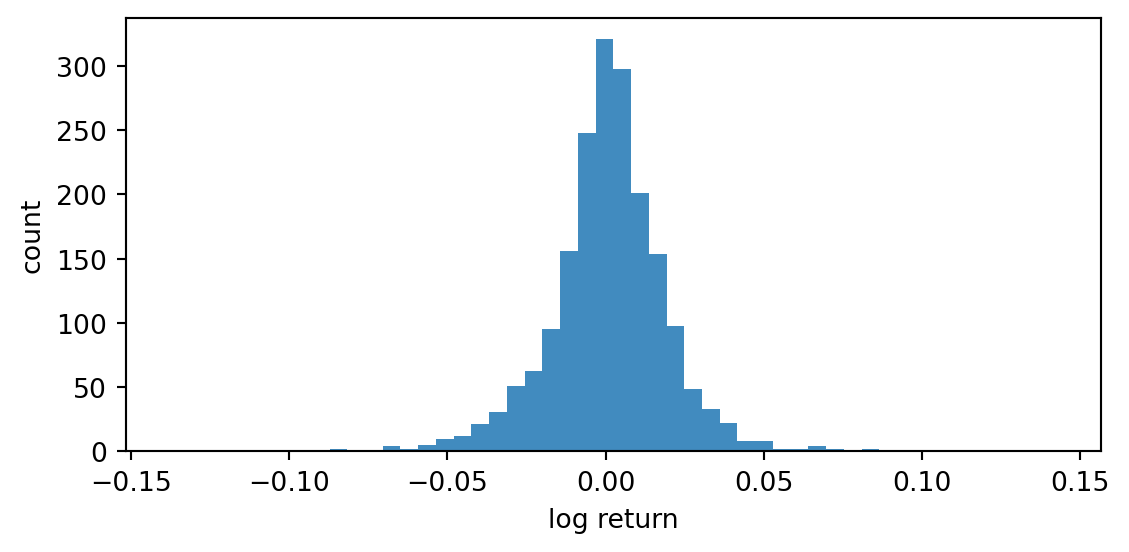

In [6]:
#| label: fig-hist
#| fig-cap: '{SYMBOL} — Daily log return histogram'
#| fig-alt: Histogram of daily log returns.
#| echo: false
fig, ax = plt.subplots(figsize=(6,3))
ax.hist(df["log_return"], bins=50, alpha=0.85)
ax.set_xlabel("log return"); ax.set_ylabel("count")
fig.tight_layout()

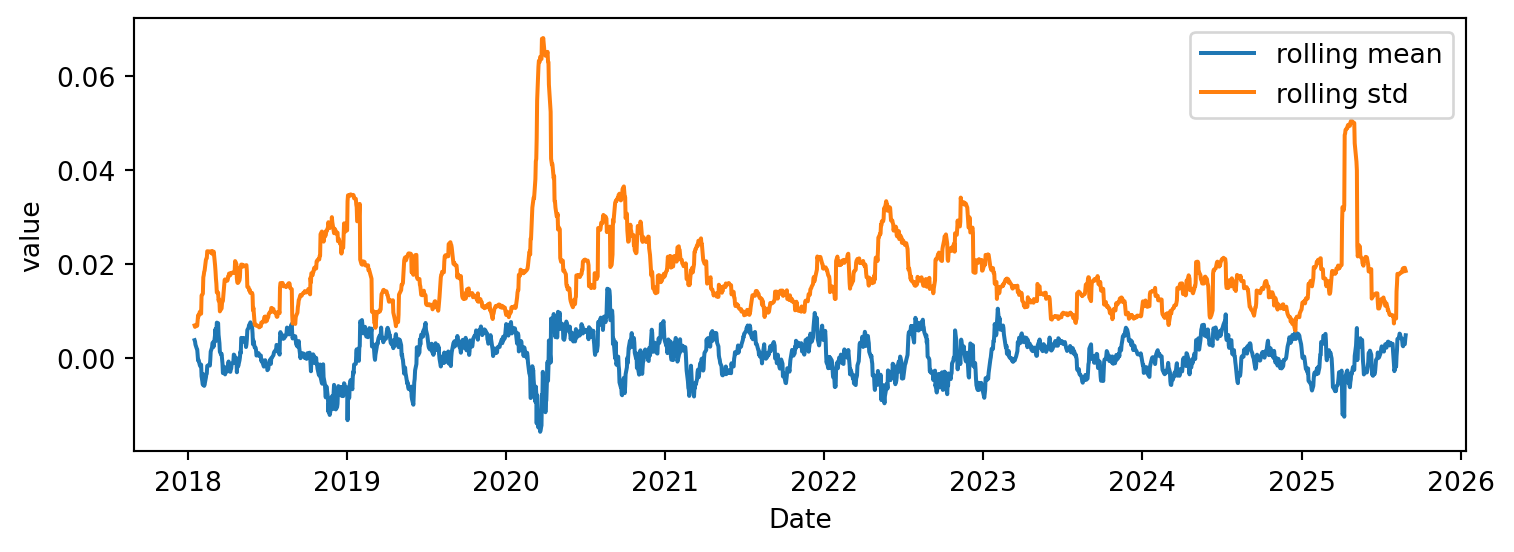

In [7]:
#| label: fig-rolling
#| fig-cap: '{SYMBOL} — Rolling mean and volatility'
#| fig-alt: Two line plots of rolling mean and rolling standard deviation of returns.
#| echo: false
fig, ax = plt.subplots(figsize=(8,3))
ax.plot(df.index, df["roll_mean"], label="rolling mean")
ax.plot(df.index, df["roll_vol"],  label="rolling std")
ax.set_xlabel("Date"); ax.set_ylabel("value")
ax.legend()
fig.tight_layout()

In [8]:
#| label: tbl-summary
#| tbl-cap: 'Summary statistics for {SYMBOL}.'
#| echo: false
summary = pd.DataFrame({
    "n_days": [len(df)],
    "start": [df.index.min().date()],
    "end":   [df.index.max().date()],
    "mean_daily_ret": [df["log_return"].mean()],
    "std_daily_ret":  [df["log_return"].std()],
    "ann_vol_approx": [df["log_return"].std()*np.sqrt(252)]
})
summary

,n_days,start,end,mean_daily_ret,std_daily_ret,ann_vol_approx
0,1914,2018-01-17,2025-08-27,0.000898,0.019663,0.312136


In [9]:
#| label: tbl-dict
#| tbl-cap: Data dictionary for computed columns.
#| echo: false
desc = {
  "close": "Adjusted closing price.",
  "volume": "Trading volume.",
  "log_return": "log(Close_t) − log(Close_{t−1}).",
  "roll_mean": f"Rolling mean of log returns (window={ROLL}).",
  "roll_vol": f"Rolling std of log returns (window={ROLL})."
}
# Build a mapping: first-level name -> combined dtype(s)
dtype_by_price = (
    df.dtypes                          # Series indexed by (Price, Ticker)
      .groupby(level=0)                # group by first level "Price"
      .apply(lambda s: " / ".join(sorted({str(dt) for dt in s})))
)

dd = pd.DataFrame({
    "column": list(desc.keys()),
    "dtype": [dtype_by_price.get(c, "MISSING") for c in desc.keys()],
    "description": list(desc.values())
})
dd
# dd = pd.DataFrame({ 
#   "column": list(desc.keys()), 
#   "dtype": [str(df[c].dtype) for c in desc.keys()], 
#   "description": list(desc.values()) }) 
# dd

,column,dtype,description
0,close,float64,Adjusted closing price.
1,volume,int64,Trading volume.
2,log_return,float64,log(Close_t) − log(Close_{t−1}).
3,roll_mean,float64,Rolling mean of log returns (window=20).
4,roll_vol,float64,Rolling std of log returns (window=20).
